<a href="https://colab.research.google.com/github/paulynamagana/afdb-api-course/blob/main/3_AFDB_BigQuery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Accessing AlphaFold DB structures through BigQuery**

### **Introduction**
<img src="https://www.vectorlogo.zone/logos/google_bigquery/google_bigquery-icon.svg" height="200" align="right">

The metadata for all ~214 million predicted structure models from AlphaFold can be accessed with BigQuery.

**IMPORTANT: The free tier of Google Cloud comes with BigQuery Sandbox with 1 TB of free processed query data each month. Repeated queries within a month could exceed this limit and if you have upgraded to a paid Cloud Billing account you may be charged.**

*This should be sufficient for running a number of queries on the metadata table, though the usage depends on the size of the columns queried and selected. Please look at the BigQuery pricing page for more information. This is the user's responsibility so please ensure you keep track of your billing settings and resource usage in the console.*

**IMPORTANT:** <br>
Before we get started, it's important to note that you will need to carefully follow the provided instructions that will help you set up the required environment and configure the necceasary dependencies. Make sure you have access to a Google account, as we will be using Google Colab and BigQuery.


<br>

In order to customise the code you will need to **Save a copy** of this Notebook to your Drive. You can visit this resource [Query Syntax](https://cloud.google.com/bigquery/docs/reference/standard-sql/query-syntax#select_list) for further information about SQL queries in GoogleSQL for BigQuery.





---
## Before you start, set up BigQuery <a name="Set up Big Query"></a>

Before you start running any code below, follow the BigQuery Sandbox [Set up guide](https://cloud.google.com/bigquery/docs/sandbox). The link also discusses options to upgrade if the limited capabilities are not enough for your work. Moreover, it highlights the limitations of this sandbox.

To set up a BigQuery Sandbox and get started with accessing AlphaFold DB structures, follow these instructions:

1. Log in to your Google Account, if you don't have a Google account, create one by clicking on "Create account" and following the on-screen instructions.
2. Go to the [BigQuery page](https://console.cloud.google.com/bigquery)
. Start using the sandbox by creating a project name of your choice (follow instructions in the link above). </br>
  *Important Note: When setting up your BigQuery Sandbox, please be aware that it does not accept names with spaces or underscores. Make sure to choose names that consist of alphanumeric characters only and separate words with dashes.*
3. Copy your `project-id` to use in the cell to Authenticate and create a client to access BigQuery.




---



## How to use Google Colab <a name="How to use GoogleColab"></a>
1. To run a code cell, click on the cell to select it. You will notice a play button (▶️) on the left side of the cell. Click on the play button or press Shift+Enter to **run** the code in the selected cell.
2. The code will start executing, and you will see the output, if any, displayed below the code cell.
3. Move to the next code cell and repeat steps 2 and 3 until you have executed all the desired code cells in sequence.
4. The currently running step is indicated by a circle with a stop sign next to it.
If you need to stop or interrupt the execution of a code cell, you can click on the stop button (■) located next to the play button.

*Remember to run the code cells in the correct order, as their execution might depend on variables or functions defined in previous cells. You can modify the code in a code cell and re-run it to see updated results.*



In [1]:
#@title #Change `project_id` and run this cell
from google.colab import auth
from google.cloud import bigquery
from google.colab import data_table
data_table.enable_dataframe_formatter()
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Authenticate and create a client to access BigQuery
auth.authenticate_user()
project_id = "smooth-kiln-413413"#@param {type:"string"}
#@markdown `project_id` is not the same as project name. To see the `project_id` visit your [dashboard](https://console.cloud.google.com/cloud-resource-manager?)

client = bigquery.Client(project=project_id)


def execute_bigquery_and_create_dataframe(query):
    """
    Execute a BigQuery query, parse the results, and create a pandas DataFrame.

    Parameters:
    - query (str): The SQL query to be executed.
    - client: The BigQuery client.

    Returns:
    - pd.DataFrame: A pandas DataFrame containing the query results.
    """
    # Execute the query and retrieve the results using BigQuery client
    client = bigquery.Client(project=project_id)
    query_job = client.query(query)
    results = query_job.result()

    # Suppress all warnings
    warnings.filterwarnings("ignore")
    # Parse the results and store them as a list of dictionaries
    data = [dict(row) for row in results]

    # Create a pandas DataFrame to view the results as a table
    df = pd.DataFrame(data)

    # Display the DataFrame for visualization
    display(df)

    return df


## **1.&nbsp;  Data Types**
The code blocks below query the column names and their respective data types of the entire table. This ensures the column names are up-to-date and also facilitates a clear view of the metadata table's structure, for subseqeunt new queries. Moreover, this also tests if your setup is working correctly.

In [2]:
#SQL query to retrieve column names and corresponding data types for the 'metadata' table
query = """
      SELECT column_name, data_type -- Selecting the column names and data types

      FROM bigquery-public-data.deepmind_alphafold.INFORMATION_SCHEMA.COLUMNS
      WHERE table_name = 'metadata' -- Filtering the results for the 'metadata' table
"""

#Big Query
df = execute_bigquery_and_create_dataframe(query)

,column_name,data_type
0,allVersions,ARRAY<INT64>
1,latestVersion,INT64
2,organismCommonNames,ARRAY<STRING>
3,uniprotEnd,INT64
4,proteinShortNames,ARRAY<STRING>
5,uniprotStart,INT64
6,fractionPlddtConfident,FLOAT64
7,organismSynonyms,ARRAY<STRING>
8,fractionPlddtVeryHigh,FLOAT64
9,proteinFullNames,ARRAY<STRING>


You can read the description of each column, observed below in your query.

|**Column name**	| **Data type** |	**Description**|
---------|-----------|--------------------- |
|allVersions|	ARRAY <INT64>|	An array of AFDB versions this prediction has had
|entryId	| STRING	| The AFDB entry ID, e.g. "AF-Q1HGU3-F1"|
|fractionPlddtConfident	|FLOAT64	|Fraction of the residues in the prediction with pLDDT between 70 and 90|
|fractionPlddtLow	|FLOAT64	|Fraction of the residues in the prediction with pLDDT between 50 and 70|
|fractionPlddtVeryHigh	|FLOAT64	|Fraction of the residues in the prediction with pLDDT greater than 90|
|fractionPlddtVeryLow	|FLOAT64	|Fraction of the residues in the prediction with pLDDT less than 50|
|globalMetricValue	|FLOAT64	|The mean pLDDT of this prediction|
|isReferenceProteome	|BOOL	|Is this protein part of the reference proteome?
|isReviewed	|BOOL|	Has this protein been reviewed, i.e. is it part of SwissProt?|
|latestVersion	|INT64|	The latest AFDB version for this prediction
|modelCreatedDate	|DATE	|The date of creation for this entry, e.g. "2022-06-01"
|organismCommonNames	|ARRAY<STRING>|	List of common organism names
|organismScientificName	|STRING|	The scientific name of the organism
|organismSynonyms	|ARRAY<STRING>	|List of synonyms for the organism
|proteinFullNames	|ARRAY<STRING>	|Full names of the protein
|proteinShortNames	|ARRAY<STRING>|	Short names of the protein
|sequenceChecksum	|STRING	|CRC64 hash of the sequence. Can be used for cheaper lookups.
|sequenceVersionDate	|DATE	|Date when the sequence data was last modified in UniProt

<br>

For more detailed information, check the [GitHub repository](https://github.com/deepmind/alphafold/blob/main/afdb/README.md#exploring-the-metadata)



## **2.&nbsp;  Basic Query**
Now, we can start querying for specific entries to work with, depending on the data you require for downstream purposes. To explore the data, this next query will return the first 10 entries to view the data for them.

In [3]:
#@title 2.1 Finding entries by organism
# This query retrieves entries for proteins from a specific organism
#Replace `"Homo sapiens"` in the query with the scientific name of the organism you are interested in.

query = """
      SELECT entryId, uniprotId, organismScientificName
      FROM `bigquery-public-data.deepmind_alphafold.metadata`
      WHERE organismScientificName = "Homo sapiens"
      LIMIT 20
"""

df_same_protein = execute_bigquery_and_create_dataframe(query)

,entryId,uniprotId,organismScientificName
0,AF-V9J4Q5-F1,V9J4Q5_HUMAN,Homo sapiens
1,AF-F2VNJ7-F1,F2VNJ7_HUMAN,Homo sapiens
2,AF-J7HDH6-F1,J7HDH6_HUMAN,Homo sapiens
3,AF-Q5JTQ6-F1,Q5JTQ6_HUMAN,Homo sapiens
4,AF-H0YAJ6-F1,H0YAJ6_HUMAN,Homo sapiens
5,AF-H0YH72-F1,H0YH72_HUMAN,Homo sapiens
6,AF-H0Y3J4-F1,H0Y3J4_HUMAN,Homo sapiens
7,AF-A0A5C2GIY5-F1,A0A5C2GIY5_HUMAN,Homo sapiens
8,AF-A0A5C2GSV3-F1,A0A5C2GSV3_HUMAN,Homo sapiens
9,AF-A0A5C2GIH0-F1,A0A5C2GIH0_HUMAN,Homo sapiens


In [4]:
#@title 2.2 Retrieve a limited set of data from the AlphaFold metadata table
## SQL query to retrieve a limited set of data from the AlphaFold metadata table
query = """
        SELECT *

        FROM `bigquery-public-data.deepmind_alphafold.metadata` --DATASET
        LIMIT 10 --LIMIT THE QUERY
"""
# Suppress all warnings

df_limited = execute_bigquery_and_create_dataframe(query)

,allVersions,latestVersion,organismCommonNames,uniprotEnd,proteinShortNames,uniprotStart,fractionPlddtConfident,organismSynonyms,fractionPlddtVeryHigh,proteinFullNames,...,uniprotId,modelCreatedDate,fractionPlddtVeryLow,sequenceVersionDate,entryId,geneSynonyms,uniprotSequence,gene,isReferenceProteome,isReviewed
0,"[3, 4]",4,[Yellowfever mosquito],185,[],1,0.157,[Culex aegypti],0.632,[],...,Q1HQV0_AEDAE,2022-06-01,0.135,2006-06-13,AF-Q1HQV0-F1,[],MLVRSTIGKICRNPQIFNNALPCNGILSIPILHANPVRNGSFRSSE...,5577385,True,False
1,"[3, 4]",4,[],101,[],1,0.030,[],0.891,[],...,Q1I986_PSEE4,2022-06-01,0.069,2006-06-13,AF-Q1I986-F1,[],MRIREETYWQWADAQLHSRSHDEELSDGTSLDVQVRLSRLGATQLF...,PSEEN3022,True,False
2,"[3, 4]",4,[],137,[],1,0.146,[],0.818,[],...,Q1IB76_PSEE4,2022-06-01,0.000,2006-06-13,AF-Q1IB76-F1,[],MRYTLLDGQRDFILLVARTLLMILFVLSGWSKLTGFEGTVAYMTSL...,PSEEN2275,True,False
3,"[3, 4]",4,[],266,[],1,0.026,[],0.808,[],...,Q1I3W2_PSEE4,2022-06-01,0.064,2006-06-13,AF-Q1I3W2-F1,[],MPLTRALLSLLRPAGLLLLICLSPQAHSERLRIVSDDWAPYLYQVN...,PSEEN5040,True,False
4,"[3, 4]",4,[],69,[],1,0.159,[],0.812,[],...,Q1I611_PSEE4,2022-06-01,0.000,2006-06-13,AF-Q1I611-F1,[],MSSRETGNVKWFNDAKGYGFIQREGGADVFVHYRAIRGEGHRTLVE...,PSEEN4235,True,False
5,"[3, 4]",4,[],454,[],1,0.302,[],0.399,[],...,Q1IGG8_PSEE4,2022-06-01,0.183,2006-06-13,AF-Q1IGG8-F1,[],MTEPLKLAVVGHTNVGKTSLLRTLTRDVGFGEVSHRPSTTRHVEGA...,PSEEN0271,True,False
6,"[2, 3, 4]",4,[],205,[],1,0.073,[],0.810,[],...,LOLB_PSEE4,2022-06-01,0.005,2006-06-13,AF-Q1IEY4-F1,[],MFLRHCITFTLIALLAGCAGFGSKEAVQGQGNPQLWRQHKQQLSGL...,lolB,True,True
7,"[3, 4]",4,[],96,[],1,0.042,[],0.000,[],...,Q1IU16_KORVE,2022-06-01,0.177,2006-06-13,AF-Q1IU16-F1,[],MPEFSCGVLGKLASNGQMAITRLKRAIWLLIGWVLLVAGIVGLFLP...,Acid345_0629,True,False
8,"[3, 4]",4,[],359,[],1,0.109,[],0.825,[],...,Q1IM47_KORVE,2022-06-01,0.064,2006-06-13,AF-Q1IM47-F1,[],MKCRFAALGALLFLNFASSAFALDKTAEDLMNAGHYKRARAIAQQR...,Acid345_3052,True,False
9,"[3, 4]",4,[],265,[],1,0.042,[],0.925,[],...,Q1IS86_KORVE,2022-06-01,0.026,2006-06-13,AF-Q1IS86-F1,[],MASPSNPAVKIYEFIEFEIADGLARISLNHPPYNVLTVPLMTELAE...,Acid345_1262,True,False


##**3. Advanced Query**

This section explores more complex queries that allow for filtering, aggregation, and analysis of the AlphaFold DB metadata. These queries are designed to extract specific subsets of data and derive meaningful insights relevant to structural biology research.

###**3.1&nbsp; Retrieve a protein for all organisms**

In this case we're retrieving only the information from the next columns:

* organismScientificName
* globalMetricValue
* uniprotId
* entryId
* modelCreatedDate
* latestVersion
* sequenceVersionDate
* uniprotSequence

You can modify the query accordingly, look for the comment `-- COLUMNS TO RETRIEVE`

In [9]:
# Define the SQL query to retrieve specific columns from the 'metadata' table
query = """
SELECT
    organismScientificName,    -- Organism scientific name
    proteinShortNames,         -- Short names of the protein
    gene,                       -- Gene information
    globalMetricValue,          -- The mean pLDDT of this prediction
    uniprotId,                  -- The Uniprot EntryName field
    entryId,                    -- The AFDB entry ID, e.g. "AF-Q1HGU3-F1"
    modelCreatedDate,           -- The date of creation for this entry, e.g. "2022-06-01"
    latestVersion,              -- The latest AFDB version for this prediction
    sequenceVersionDate,        -- Date when the sequence data was last modified in UniProt
    uniprotSequence             -- Amino acid sequence for this prediction
FROM
    bigquery-public-data.deepmind_alphafold.metadata -- From the AFDB in Google Cloud Storage
WHERE
    gene = "OR1L1"  -- Filtering by gene name "OR1L1"
"""

df_organisms =execute_bigquery_and_create_dataframe(query)

,organismScientificName,proteinShortNames,gene,globalMetricValue,uniprotId,entryId,modelCreatedDate,latestVersion,sequenceVersionDate,uniprotSequence
0,Callithrix jacchus,[],OR1L1,59.06,A0A2R8MFJ2_CALJA,AF-A0A2R8MFJ2-F1,2022-06-01,4,2019-12-11,MGRNNLTRPSEFILLGLSSQPKHQKPLFAVFLPIYLVTMIGNLLII...
1,Ailuropoda melanoleuca,[],OR1L1,83.06,G1MCH8_AILME,AF-G1MCH8-F1,2022-06-01,4,2021-06-02,MGRNNLTRPSEFILLGLSSRPEDQKTLFAVFLPIYLITVIGNLLII...
2,Gorilla gorilla gorilla,[],OR1L1,70.75,G3SGI0_GORGO,AF-G3SGI0-F1,2022-06-01,4,2018-02-28,MERNHNPDNCNVLNFFFADKKNKRRNFGQIVSDVGRICYSVSLSLG...
3,Bos taurus,[],OR1L1,79.38,E1BBF4_BOVIN,AF-E1BBF4-F1,2022-06-01,4,2011-11-16,VSYVGRVFHNDDLSLGKPKTMGRTNITRPTEFILLGLSSRPEDQKP...
4,Macaca nemestrina,[],OR1L1,65.62,A0A2K6BCC1_MACNE,AF-A0A2K6BCC1-F1,2022-06-01,4,2018-03-28,PLFAVFLPIYLVTVIGNLLIILAIQSDTCLQTPMYFFLSVLSFVDI...
5,Loxodonta africana,[],OR1L1,84.25,G3U6R2_LOXAF,AF-G3U6R2-F1,2022-06-01,4,2011-11-16,NLTRPSEFILLGISSRPEDQKPLFVFFLTVYLITVMGNLIVILAIH...
6,Felis catus,[],OR1L1,83.19,A0A5F5XRU2_FELCA,AF-A0A5F5XRU2-F1,2022-06-01,4,2019-12-11,MGKSNLTRPSEFILLGLSSRPEDQKPLFAVFLPIYLITVIGNVLII...
7,Suricata suricatta,[],OR1L1,82.44,A0A673TFC7_SURSU,AF-A0A673TFC7-F1,2022-06-01,4,2020-06-17,MGRSNLTRPSEFILLGLSSRPEDQKPLFAVFLPIYLITVIGNLLII...
8,Cercocebus atys,[],OR1L1,69.62,A0A2K5M104_CERAT,AF-A0A2K5M104-F1,2022-06-01,4,2018-03-28,DQKPLFAVFLPIYLVTVIGNLLIILAIQSDTRLQTPLYFFLSVLSF...
9,Saimiri boliviensis boliviensis,[],OR1L1,70.69,A0A2K6V7P7_SAIBB,AF-A0A2K6V7P7-F1,2022-06-01,4,2018-03-28,EFILLGLSSRPEDQKPLFAVFLTIYLTTVIGNLLIIMAITPMYFFL...


###**3.2&nbsp;  Create a subset with pLDDT <70 for an Organism**
The next query involves creating subsets of proteins according to various criteria. For example, the next query below only includes proteins from *Homo sapiens* for which over half the residues are confident or better (>70 pLDDT).

In [11]:
# Define the SQL query with a LIMIT clause to retrieve specific columns
query = """
    SELECT
        entryId,                   -- The AFDB entry ID, e.g. "AF-Q1HGU3-F1"
        modelCreatedDate,          -- The date of creation for this entry, e.g. "2022-06-01"
        uniprotId,                 -- UniProt ID
        uniprotDescription,        -- UniProt description
        sequenceVersionDate        -- Date when the sequence data was last modified in UniProt
    FROM
        bigquery-public-data.deepmind_alphafold.metadata

    WHERE
        organismScientificName = "Staphylococcus aureus"   -- Filter by organism
        AND (fractionPlddtVeryHigh + fractionPlddtConfident) > 0.5   -- Filter by pLDDT
        AND isReviewed IS True    -- Filter by reviewed entries
    LIMIT
        30   -- Limit the number of results to 30
"""

# Execute the BigQuery query and create a DataFrame
df_subset = execute_bigquery_and_create_dataframe(query)


,entryId,modelCreatedDate,uniprotId,uniprotDescription,sequenceVersionDate
0,AF-Q9LC45-F1,2022-06-01,TARA_STAAU,N-acetylglucosaminyldiphosphoundecaprenol N-ac...,2005-12-06
1,AF-P02983-F1,2022-06-01,TCR_STAAU,Tetracycline resistance protein,2004-08-31
2,AF-P41972-F1,2022-06-01,SYI1_STAAU,Isoleucine--tRNA ligase,1995-11-01
3,AF-P0A0C3-F1,2022-06-01,REPB_STAAU,Replication protein,1987-08-13
4,AF-P68802-F1,2022-06-01,SAK_STAAU,Staphylokinase,1986-07-21
5,AF-P37386-F1,2022-06-01,CADA2_STAAU,Probable cadmium-transporting ATPase,1994-10-01
6,AF-P0C1U7-F1,2022-06-01,SLE1_STAAU,N-acetylmuramoyl-L-alanine amidase sle1,2006-09-05
7,AF-Q9FD08-F1,2022-06-01,SPLA1_STAAU,Serine protease SplA,2001-03-01
8,AF-P39855-F1,2022-06-01,CAPF_STAAU,Capsular polysaccharide biosynthesis protein CapF,1995-02-01
9,AF-Q9L523-F1,2022-06-01,SRRB_STAAU,Sensor protein SrrB,2000-10-01


###3.3 Visualise protein length per specie

In [12]:
query = """
SELECT
    uniprotId,
    LENGTH(uniprotSequence) AS sequence_length,
    globalMetricValue AS mean_plddt,
    organismScientificName
FROM
    `bigquery-public-data.deepmind_alphafold.metadata`
WHERE
    taxID = 272634 # TaxID for Mycoplasma pneumoniae
"""


#see https://www.uniprot.org/taxonomy/272634

# Execute the query and create a DataFrame
df = execute_bigquery_and_create_dataframe(query)

,uniprotId,sequence_length,mean_plddt,organismScientificName
0,Y594_MYCPN,122,67.07,Mycoplasma pneumoniae (strain ATCC 29342 / M129)
1,Y388_MYCPN,128,86.20,Mycoplasma pneumoniae (strain ATCC 29342 / M129)
2,ODPB_MYCPN,327,97.24,Mycoplasma pneumoniae (strain ATCC 29342 / M129)
3,SYC_MYCPN,437,93.63,Mycoplasma pneumoniae (strain ATCC 29342 / M129)
4,Y666_MYCPN,251,85.13,Mycoplasma pneumoniae (strain ATCC 29342 / M129)
...,...,...,...,...
681,HGPRT_MYCPN,175,93.83,Mycoplasma pneumoniae (strain ATCC 29342 / M129)
682,TOP1_MYCPN,711,87.59,Mycoplasma pneumoniae (strain ATCC 29342 / M129)
683,RL27_MYCPN,104,84.93,Mycoplasma pneumoniae (strain ATCC 29342 / M129)
684,RL4_MYCPN,212,90.10,Mycoplasma pneumoniae (strain ATCC 29342 / M129)


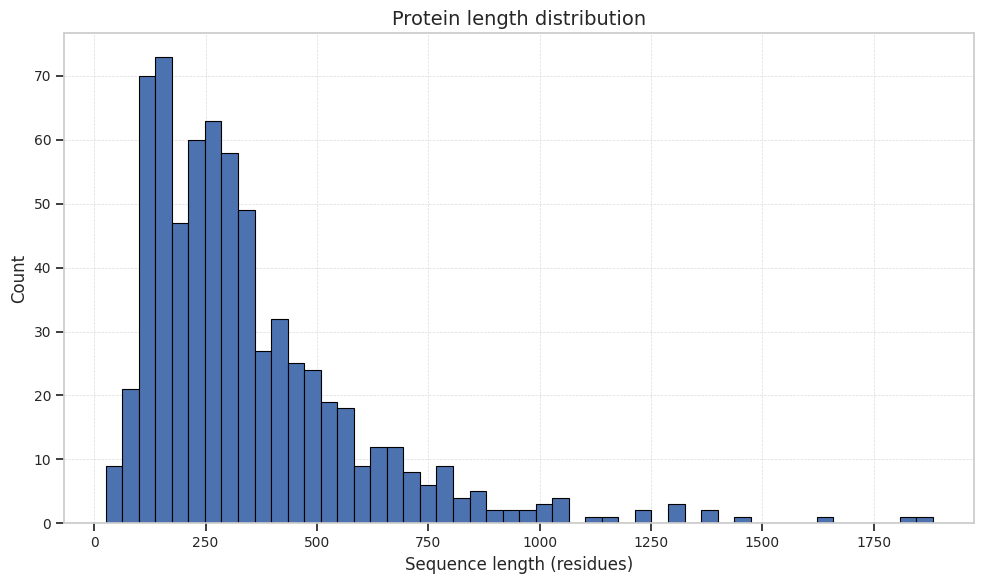

In [13]:
#plot
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
plt.hist(df['sequence_length'], bins=50, color='#4C72B0', edgecolor='black', linewidth=0.8)

plt.title('Protein length distribution', fontsize=14)
plt.xlabel('Sequence length (residues)', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Improve ticks
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tick_params(axis='both', which='both', direction='out', bottom=True, left=True)

# Grid style
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Tight layout
plt.tight_layout()
plt.show()

The histogram above shows the distribution of protein sequence lengths in *Mycoplasma pneumoniae*. You can observe the frequency of different length ranges, which can provide insights into the typical size of proteins in this organism.

### **3.4&nbsp; Exploring Protein Length and Confidence**

It's often useful to investigate if there's a relationship between the length of a protein and the confidence of its predicted structure. This section explores whether longer proteins tend to have lower average prediction confidence (pLDDT).

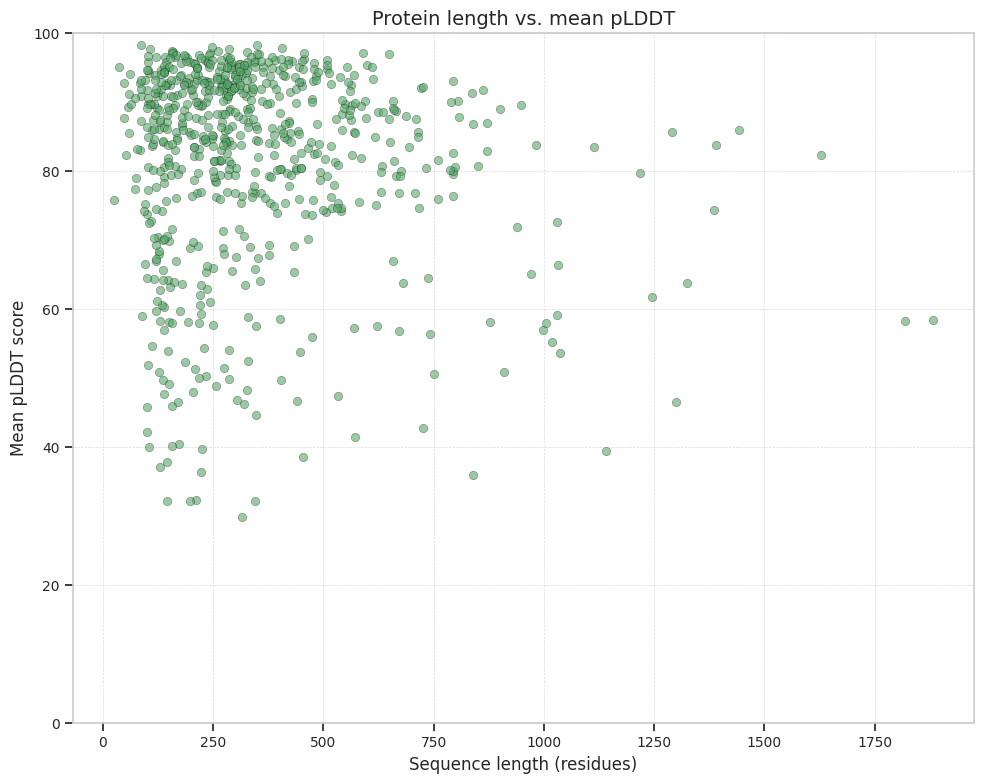

In [15]:
#plot
sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))
plt.scatter(df['sequence_length'], df['mean_plddt'], alpha=0.6, color='#55A868', edgecolors='black', linewidths=0.3)

plt.title('Protein length vs. mean pLDDT', fontsize=14)
plt.xlabel('Sequence length (residues)', fontsize=12)
plt.ylabel('Mean pLDDT score', fontsize=12)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tick_params(axis='both', which='both', direction='out', bottom=True, left=True)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

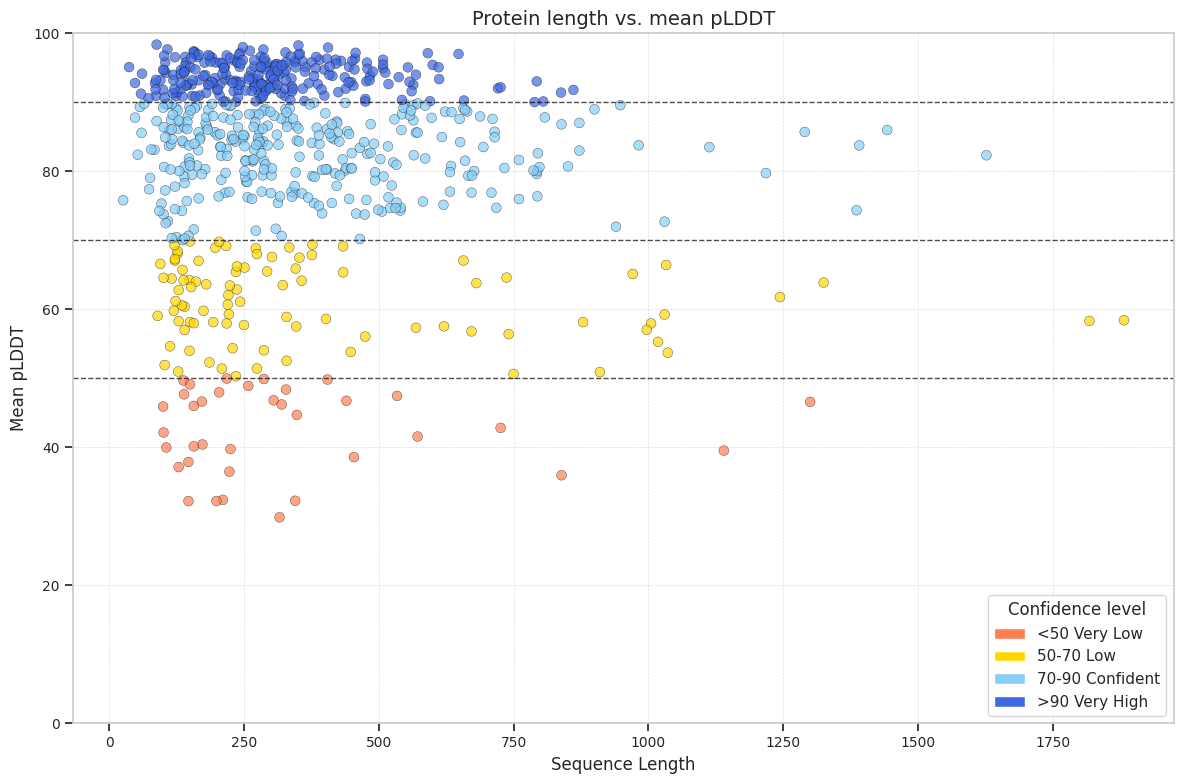

In [16]:
# Alternative version
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

def get_confidence_color(plddt):
    if plddt < 50:
        return 'coral'
    elif plddt < 70:
        return 'gold'
    elif plddt < 90:
        return 'lightskyblue'
    else:
        return 'royalblue'

# Apply color mapping
colors = df['mean_plddt'].apply(get_confidence_color)

# Create scatter plot
plt.scatter(df['sequence_length'], df['mean_plddt'],
           c=colors,
           alpha=0.7,
           s=50,
           edgecolors='black',
           linewidth=0.3)

plt.title('Protein length vs. mean pLDDT', fontsize=14)
plt.xlabel('Sequence Length', fontsize=12)
plt.ylabel('Mean pLDDT', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

# Add confidence  boundaries
plt.axhline(y=50, color='black', linestyle='--', alpha=0.7, linewidth=1)
plt.axhline(y=70, color='black', linestyle='--', alpha=0.7, linewidth=1)
plt.axhline(y=90, color='black', linestyle='--', alpha=0.7, linewidth=1)

# Create custom legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='coral', label='<50 Very Low'),
    Patch(facecolor='gold', label='50-70 Low'),
    Patch(facecolor='lightskyblue', label='70-90 Confident'),
    Patch(facecolor='royalblue', label='>90 Very High')
]
plt.legend(handles=legend_elements, title='Confidence level', loc='lower right')

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tick_params(axis='both', which='both', direction='out', bottom=True, left=True)

# Grid styling
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Axis limit
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

In [17]:
# Print some correlation statistics
correlation = df['sequence_length'].corr(df['mean_plddt'])
print(f"Correlation between sequence length and mean pLDDT: {correlation:.3f}")

# Print statistics by confidence level
print("\nStatistics by confidence level:")
confidence_bands = [
    (0, 50, 'Very Low'),
    (50, 70, 'Low'),
    (70, 90, 'Confident'),
    (90, 100, 'Very High')
]

for min_val, max_val, label in confidence_bands:
    if max_val == 100:
        subset = df[(df['mean_plddt'] >= min_val) & (df['mean_plddt'] <= max_val)]
    else:
        subset = df[(df['mean_plddt'] >= min_val) & (df['mean_plddt'] < max_val)]

    if len(subset) > 0:
        avg_length = subset['sequence_length'].mean()
        print(f"{label} ({min_val}-{max_val}): {len(subset)} proteins, avg length: {avg_length:.1f}")

Correlation between sequence length and mean pLDDT: -0.106

Statistics by confidence level:
Very Low (0-50): 36 proteins, avg length: 333.7
Low (50-70): 92 proteins, avg length: 394.7
Confident (70-90): 310 proteins, avg length: 377.6
Very High (90-100): 248 proteins, avg length: 298.6


### **3.5&nbsp; pLDDT Score Distribution**

To further understand the overall quality of the predicted structures for *Mycoplasma pneumoniae*, we can analyze the distribution of the average pLDDT scores. This will show us how many proteins fall into different confidence categories (Very Low, Low, Confident, Very High).

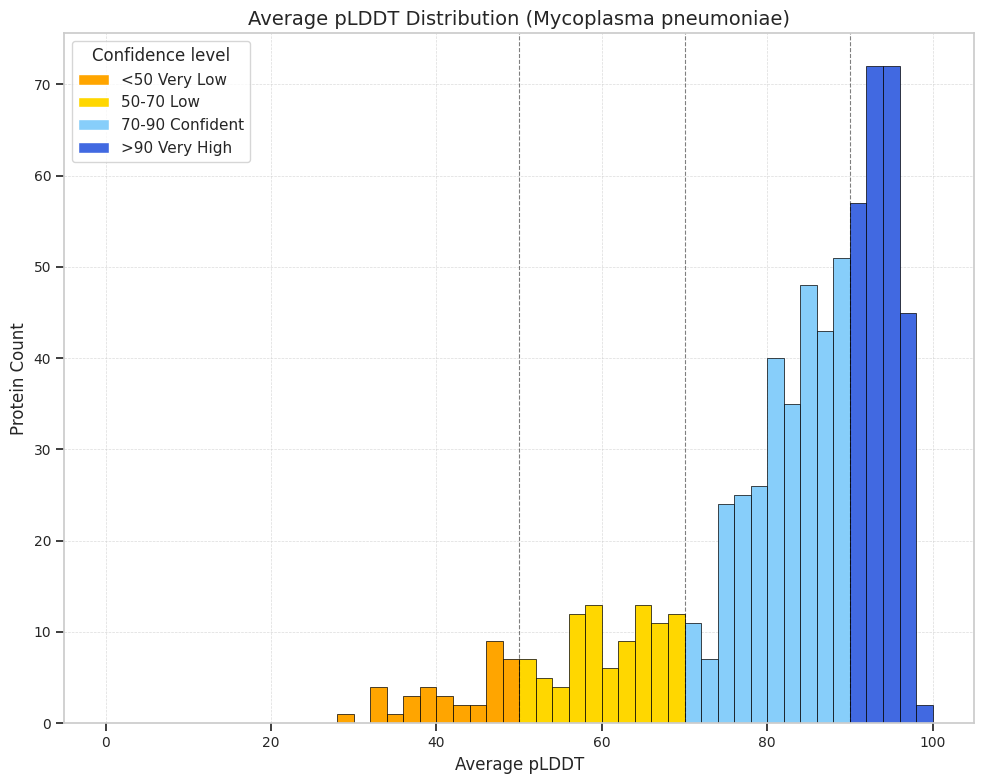

In [18]:

sns.set(style="whitegrid")
# Define confidence intervals for coloring
confidence_ranges = [
    (0, 50, 'orange', '<50 Very Low'),
    (50, 70, 'gold', '50-70 Low'),
    (70, 90, 'lightskyblue', '70-90 Confident'),
    (90, 100, 'royalblue', '>90 Very High')
]

# Create many more bins for detailed distribution (similar to your reference image)
num_bins = 50  # You can adjust this number - try 30, 50, or even 100
bin_edges = np.linspace(0, 100, num_bins + 1)

# Create the histogram
plt.figure(figsize=(10, 8))
n, bins, patches = plt.hist(df['mean_plddt'], bins=bin_edges, edgecolor='black', linewidth=0.5)

plt.title('Average pLDDT Distribution (Mycoplasma pneumoniae)', fontsize=14)
plt.xlabel('Average pLDDT', fontsize=12)
plt.ylabel('Protein Count', fontsize=12)

# Color the bars based on confidence intervals
for patch in patches:
    bin_center = (patch.get_x() + patch.get_width() / 2)

    # Determine which confidence range this bin belongs to
    for min_val, max_val, color, label in confidence_ranges:
        if min_val <= bin_center < max_val:
            patch.set_facecolor(color)
            break
    else:
        # Handle the edge case for bins at exactly 100
        if bin_center >= 90:
            patch.set_facecolor('royalblue')

# Add vertical lines to separate confidence bands
confidence_boundaries = [50, 70, 90]
for boundary in confidence_boundaries:
    plt.axvline(x=boundary, color='black', linestyle='--', linewidth=0.8, alpha=0.5)

# Create custom legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color, label=label) for _, _, color, label in confidence_ranges]
plt.legend(handles=legend_elements, title='Confidence level', loc='upper left')

# Improve ticks
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tick_params(axis='both', which='both', direction='out', bottom=True, left=True)

# Grid styling
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Axis limit
plt.tight_layout()
plt.show()


In [19]:
#some statistics
print("--Statistics--")
print(f"Total proteins: {len(df)}")
print(f"Mean pLDDT: {df['mean_plddt'].mean():.2f}")
print(f"Median pLDDT: {df['mean_plddt'].median():.2f}")
print(f"Standard deviation: {df['mean_plddt'].std():.2f}")

# Print distribution across confidence bands
print("--Distribution across plddt bands--")
for min_val, max_val, _, label in confidence_ranges:
    if max_val == 100:
        count = len(df[(df['mean_plddt'] >= min_val) & (df['mean_plddt'] <= max_val)])
    else:
        count = len(df[(df['mean_plddt'] >= min_val) & (df['mean_plddt'] < max_val)])
    percentage = (count / len(df)) * 100
    print(f"{label}: {count} proteins ({percentage:.1f}%)")

--Statistics--
Total proteins: 686
Mean pLDDT: 81.67
Median pLDDT: 85.98
Standard deviation: 14.50
--Distribution across plddt bands--
<50 Very Low: 36 proteins (5.2%)
50-70 Low: 92 proteins (13.4%)
70-90 Confident: 310 proteins (45.2%)
>90 Very High: 248 proteins (36.2%)


###**3.6&nbsp; Retrieve prediction confidence fractions per species.**

However, this query has been limited to the top 29 species according to the num_predictions as it  may take time to retrieve the full grouped dataset.

In [20]:
# SQL query to calculate mean values and count predictions for different confidence levels
query= """SELECT
          organismScientificName AS name, -- Selecting organism scientific name as column 'name'
          SUM(fractionPlddtVeryLow) / COUNT(fractionPlddtVeryLow) AS mean_plddt_very_low, -- Calculating mean for very low confidence
          SUM(fractionPlddtLow) / COUNT(fractionPlddtLow) AS mean_plddt_low, -- Calculating mean for low confidence
          SUM(fractionPlddtConfident) / COUNT(fractionPlddtConfident) AS mean_plddt_confident, -- Calculating mean for confident confidence
          SUM(fractionPlddtVeryHigh) / COUNT(fractionPlddtVeryHigh) AS mean_plddt_very_high, -- Calculating mean for very high confidence
          COUNT(organismScientificName) AS num_predictions -- Counting the number of predictions per organism

FROM bigquery-public-data.deepmind_alphafold.metadata -- From the AFDB in Google Cloud Storage
GROUP BY name -- Grouping the results by organism name
ORDER BY num_predictions DESC -- Ordering the results by the number of predictions in descending order
LIMIT 30 -- Limiting the results to the top 30 predictions
"""

#execute the query and creating dataframe
df_across_species= execute_bigquery_and_create_dataframe(query)

,name,mean_plddt_very_low,mean_plddt_low,mean_plddt_confident,mean_plddt_very_high,num_predictions
0,Acidobacteria bacterium,0.089714,0.100252,0.220046,0.589985,1066443
1,Chloroflexi bacterium,0.074611,0.088021,0.210647,0.626718,1018842
2,Actinobacteria bacterium,0.062034,0.083169,0.204845,0.649948,924571
3,Gammaproteobacteria bacterium,0.062937,0.082206,0.210893,0.643962,889963
4,Escherichia coli,0.079160,0.122607,0.249195,0.549035,864366
5,Deltaproteobacteria bacterium,0.084659,0.094105,0.223174,0.598061,809761
6,marine sediment metagenome,0.137732,0.180879,0.249305,0.432082,666660
7,Mesorhizobium sp,0.056018,0.093542,0.203185,0.647253,664158
8,Helicobacter pylori,0.075897,0.098938,0.232671,0.592496,552054
9,Bacteroidetes bacterium,0.065017,0.082766,0.222274,0.629940,485548


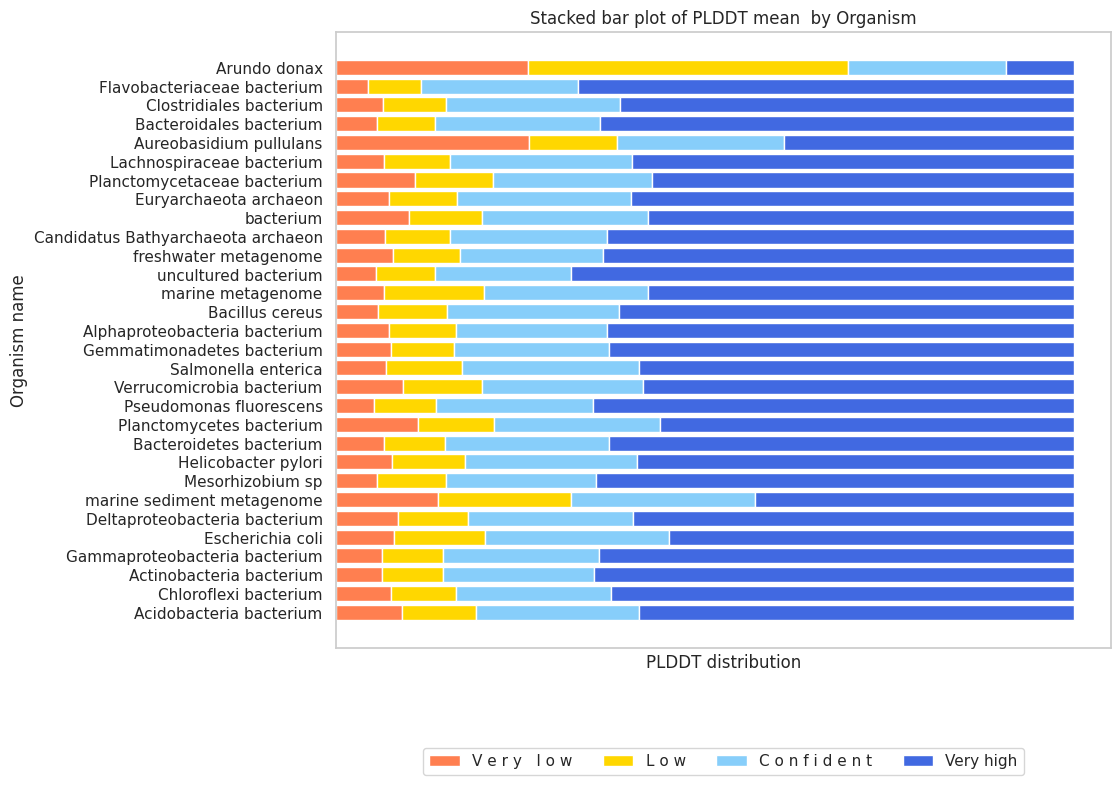

In [30]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.set(style="whitegrid")
# Define custom colors
custom_colors = {'mean_plddt_very_low': 'coral',
                 'mean_plddt_low': 'gold',
                 'mean_plddt_confident': 'lightskyblue',
                 'mean_plddt_very_high': 'royalblue'}

# Create a stacked bar plot
bottom = np.zeros(len(df_across_species['name']))
for category in custom_colors.keys():
    if category == 'mean_plddt_very_low':
        label_words = 'very low'
    elif category.endswith('low') or category.endswith('confident'):
        label_words = category.split('_')[-1]
    else:
        label_words = category.split('_')[-2:]

    label = ' '.join(label_words).capitalize()
    ax.barh(df_across_species['name'], df_across_species[category], color=custom_colors.get(category, 'gray'), label=label, left=bottom)
    bottom += df_across_species[category]

# Customize the plot
ax.set_title('Stacked bar plot of PLDDT mean  by Organism')
ax.set_xlabel('PLDDT distribution')
ax.set_ylabel('Organism name')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=4)

# Show the plot
plt.grid(False)
plt.xticks([])
plt.show()


##**4.&nbsp;   Prepare query for download**

You can customise the next code block to download the specific data from a query that you have tuned for your specific requirements.

Look for the comment `CHANGE THE NEXT LINES OF THE QUERY` and paste your query.


In [21]:
# Define the query with LIMIT clause
#YOU CAN MODIFY THE QUERY ACCORDING TO YOUR NEEDS
query = """
with file_rows AS (
  with file_cols AS (
    SELECT
      CONCAT(entryID, '-model_v4.cif') as m,
      CONCAT(entryID, '-predicted_aligned_error_v4.json') as p
    FROM bigquery-public-data.deepmind_alphafold.metadata

    ---- CHANGE THE NEXT LINES OF THE QUERY TO YOUR SPECIFIC QUERY -----
    WHERE taxID = 6239 --  taxID for C. elegans
      AND (fractionPlddtVeryHigh + fractionPlddtConfident) > 0.5 -- Filter by pLDDT
    LIMIT 10  -- Limit the query to the first 10 entries
    -----

  )
  SELECT * FROM file_cols UNPIVOT (files for filetype in (m, p))
)
SELECT CONCAT('gs://public-datasets-deepmind-alphafold-v4/', files) as files
from file_rows
"""

## Where fractionPlddtVeryHigh == Fraction of the residues in the prediction with pLDDT greater than 90
##fractionPlddtConfident ==	Fraction of the residues in the prediction with pLDDT between 70 and 90

# Execute the query
query_job = client.query(query)

# Fetch the query results
results = query_job.result()

# Create a list to store the results
file_list = []
# Iterate over the results and extract the "files" column value
for row in results:
    file_list.append(row["files"])

for entry in file_list:
  print(entry)

gs://public-datasets-deepmind-alphafold-v4/AF-P34473-F1-model_v4.cif
gs://public-datasets-deepmind-alphafold-v4/AF-P34473-F1-predicted_aligned_error_v4.json
gs://public-datasets-deepmind-alphafold-v4/AF-Q23138-F1-model_v4.cif
gs://public-datasets-deepmind-alphafold-v4/AF-Q23138-F1-predicted_aligned_error_v4.json
gs://public-datasets-deepmind-alphafold-v4/AF-A0A0K3AUF6-F1-model_v4.cif
gs://public-datasets-deepmind-alphafold-v4/AF-A0A0K3AUF6-F1-predicted_aligned_error_v4.json
gs://public-datasets-deepmind-alphafold-v4/AF-Q9XXP3-F1-model_v4.cif
gs://public-datasets-deepmind-alphafold-v4/AF-Q9XXP3-F1-predicted_aligned_error_v4.json
gs://public-datasets-deepmind-alphafold-v4/AF-Q7YTT4-F1-model_v4.cif
gs://public-datasets-deepmind-alphafold-v4/AF-Q7YTT4-F1-predicted_aligned_error_v4.json
gs://public-datasets-deepmind-alphafold-v4/AF-Q20222-F1-model_v4.cif
gs://public-datasets-deepmind-alphafold-v4/AF-Q20222-F1-predicted_aligned_error_v4.json
gs://public-datasets-deepmind-alphafold-v4/AF-Q9N4

In [ ]:
#@title **Save files to Google Drive**
#@markdown **Note:** this block of code will download all the files listed from the previous code to your Google Drive into a folder called **"AFDB_BigQuery"**.
import os
from google.colab import drive

drive.mount('/content/drive')
destination_path = '/content/drive/MyDrive/AFDB_BigQuery'

# Check whether the specified path exists or not
isExist = os.path.exists(destination_path)
if not isExist:
    # Create a new directory because it does not exist
    os.makedirs(destination_path)
    print("The new directory is created!")

# Function to download a file from Google Cloud Storage and save it to the destination
def download_gs_file(gs_url, dest_path):
    # Extract the filename from the GS URL
    filename = os.path.basename(gs_url)

    # Use gsutil to copy the file from GS to the destination path
    copy_command = f"gsutil cp {gs_url} {os.path.join(dest_path, filename)}"

    # Execute the gsutil command
    os.system(copy_command)
    print("Downloaded:", filename)

# Run this code to download the structures from Google Cloud Storage
for structure in file_list:
    # Use the download function to copy files from GS to the destination
    download_gs_file(structure, destination_path)


## Contact us

If you experience any bugs please contact afdbhelp@ebi.ac.uk




---

